# FIFA Market Value Prediction

The goal of this project is to predict the market value of footballplayers from the game FIFA based on their attributes.

In [27]:
#In order to execute this, make sure you have installed xgboost, lightgbm and bayes_opt

# Basic data transformations/preprocessing and visualization
import pandas as pd
import numpy as np
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import warnings
from sklearn.neighbors import LocalOutlierFactor
warnings.filterwarnings('ignore')


# Splitting, Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
import xgboost as xgb 
import lightgbm as lgb

# Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [2]:
# Load data
df = pd.read_csv("utils/fifa_data_without_duplicates")

# Preprocessing

## Cleaning

In [3]:
# Converts to the correct the input value to the correct number (eg. 10k --> 10,000, 1M --> 1,000,000)
def convert_to_number(value):
    value = value[1:]
    if value[-1] == "K":
        return float(value.replace("K", "")) * 1000
    elif value[-1] == "M":
        return float(value.replace("M", "")) * 1000000
    else:
        return float(value)  

In [4]:
# Data Cleaning --> Remove unnecessary characters
df['market_value'] = df['market_value'].apply(convert_to_number)
df["height"] = df["height"].str[:-2].astype(np.int64)
df["weight"] = df["weight"].str[:-2].astype(np.int64)
df["weak_foot"] = df["week_foot"].str[0].astype(int)
df["skill_moves"] = df["skill_moves"].str[0].astype(int)

# Delete players that have market value of zero
df.drop(df[df['market_value'] == 0].index, inplace = True, axis = 0)

# Delete unnecassary columns; "week_foot" deleted since we have weak_foot now spelled correctly
df_names = df[["id", "name"]]
df.drop(["joined", "name", "week_foot", "team"], axis = 1, inplace = True)

## Feature Engineering

In [5]:
# Indicate loan players
df["loan_player"] = np.where(df["contract_duration"].str.contains("loan", case = False), 1, 0)

# Get contract_end and drop players which have contract end older than 2020 (so called icons in fifa)
df["contract_end"] = df["contract_duration"].str[8:]
df["contract_end"] = df["contract_end"].str.extract('(\d+)').astype(np.float64)
df.drop(df[df['contract_end'] < 2020].index, inplace = True)

# Get contract start, for loan players this data is missing. For now we set the contract start of loan players to missing
df["contract_start"] = np.where(df["loan_player"] == True, np.nan, df["contract_duration"].str[0:6]).astype(np.float64)

# compute contract duration from 2021 onwards
df["contract_duration"] = df["contract_end"] - 2021

## Encodings

In [6]:
# Binary encoding for preferred_foot
df["preferred_foot"] = df["preferred_foot"].apply(lambda x: 0 if x == 'Left' else 1)

# One-hot-encode best_position feature
one_hot_encoder = OneHotEncoder()

df.reset_index(inplace = True, drop = True)
encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[["best_postion"]]).toarray(), 
                       columns=one_hot_encoder.get_feature_names(["best_postion"]))

df.drop(columns=["best_postion"], inplace = True)
df = df.join(encoded)

In [7]:
target = df["market_value"]
features = df.drop("market_value", axis = 1)

## Pipeline

### Missing Values Imputing

In [8]:
# Main idea of how to create custom Transformers are from: https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
class GroupedImputer(BaseEstimator, TransformerMixin):
    def __init__(self, variable, grouping) : 
        self.variable = variable
        self.grouping = grouping
        
    def fit(self, X, y=None): 
        self.map = X.groupby(self.grouping)[self.variable].median()
        return self

    def transform(self, X, y=None): 
        X[self.variable] = X[self.variable].fillna(value = X[self.grouping].map(self.map))
        return X
    
imputer = GroupedImputer(variable = "contract_start", grouping = "contract_end")

### Feature Scaling

In [9]:
features_no_scale = list(encoded.columns) + ["preferred_foot"]
features_to_scale = [feature for feature in list(features.columns) if feature not in features_no_scale]

scaler = ColumnTransformer(
   transformers =  [
        ('scaler', StandardScaler(), features_to_scale)
    ], 
    remainder='passthrough'
)

### Outlier Detection

In [10]:
# Main idea of how to create custom Transformers are from: https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
class OutlierDeletion(BaseEstimator, TransformerMixin):
    def __init__(self, threshold): 
        self.threshold = threshold
        
    def fit(self, X, y=None):
        # no fitting needed
        return self

    def transform(self, X, y=None):
        X = np.asarray(X)
        y = np.asarray(y)
        lcf = LocalOutlierFactor()
        lcf.fit(X)
        return (X[lcf.negative_outlier_factor_ > self.threshold,: ], y[lcf.negative_outlier_factor_ > self.threshold])
    
outlier_deletion = OutlierDeletion(threshold = -20)

### General Pipeline

In [11]:
pipeline = Pipeline(
    steps=[
        ('imputation', imputer),
        #('outlier_deletion', outlier_deletion),
        ('scaler', scaler),
        ("rfe", None),
        ('poly_transformer', None),
        ('estimator', None),
    ]
)

## Model Building

### First one symbolic approach: Regression Tree

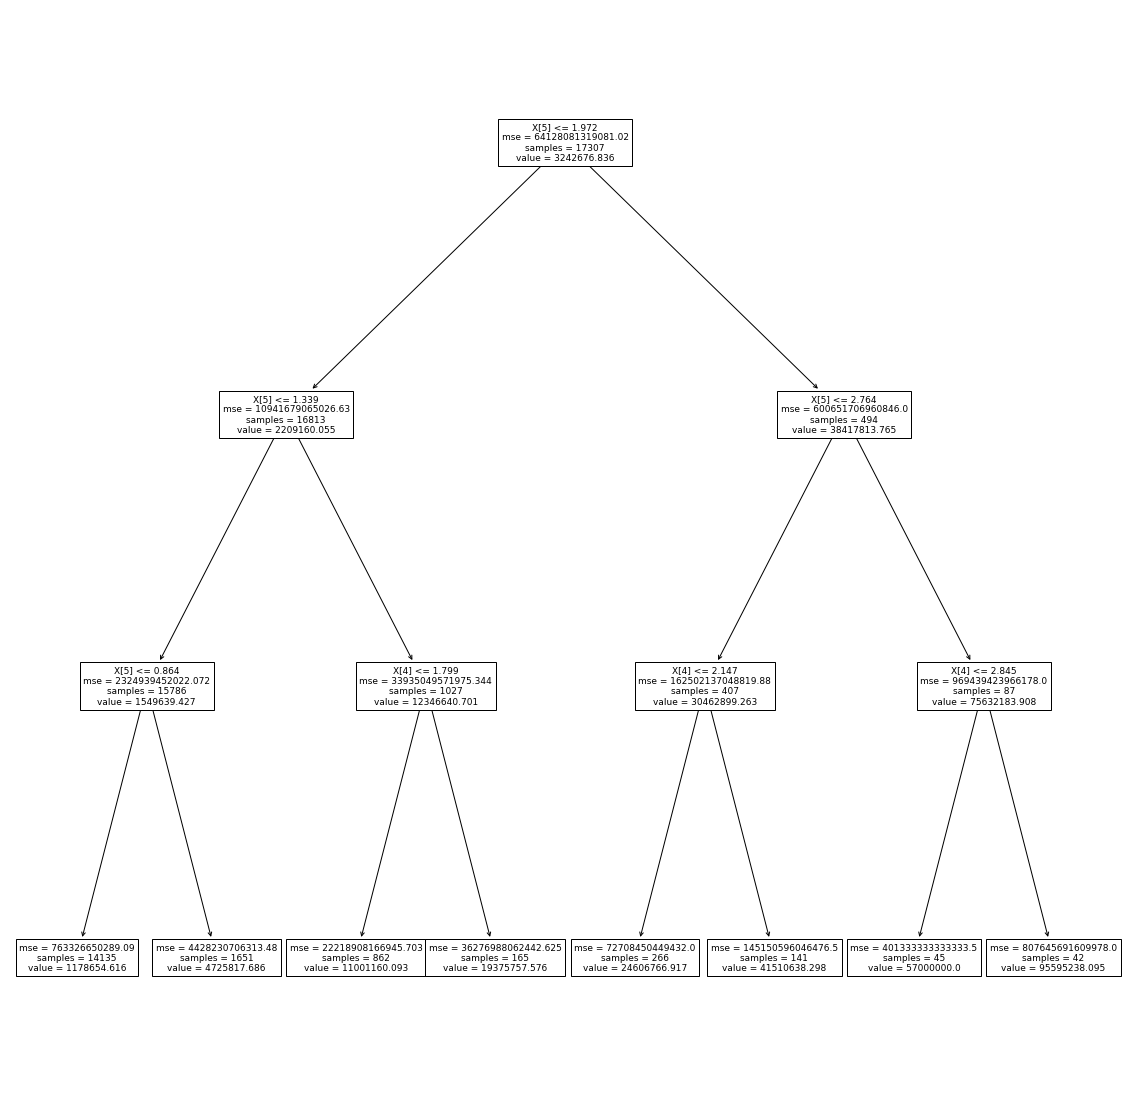

In [12]:
dt_estimator = tree.DecisionTreeRegressor(random_state = 42, max_depth = 3)
dt_reg = pipeline.set_params(estimator = dt_estimator)

dt_reg.fit(features, target)

# Plotting Tree
plt.figure(figsize=(20,20))
tree.plot_tree(dt_reg['estimator'])
plt.show()

### Run Model Selection

In [60]:
def model_selection(models, features, target):
    model_performances = pd.DataFrame()
    best_model_params = {}
    mse = make_scorer(mean_squared_error, greater_is_better=False)
    for model in models.items():
        model_name = model[0]
        regressor = model[1][0]
        param_grid = model[1][1]
        # Find suitable parameters in order to compare the models with their appropriate hyperparameters
        model = GridSearchCV(
            estimator = regressor,
            param_grid = param_grid,
            scoring = mse, 
            verbose = 0,
            cv = 10,
            n_jobs = -1
            
        )
        model.fit(features, target)
        best_model_params[model_name] = model.best_params_
        
        rmse = sqrt(abs(model.best_score_))
        model_performances[model_name] = [rmse]
        
    model_performances.index = ["RMSE"]
    
    return model_performances, best_model_params

In [48]:
# Linear Regression
from sklearn import base
lr_pipeline = base.clone(pipeline)
lr_reg = lr_pipeline.set_params(rfe = RFE(LinearRegression()), estimator = LinearRegression())
lr_params = {"rfe__n_features_to_select": [10, 20, 30 , 42]}

# Polynominal Regression
pol_pipeline = base.clone(pipeline)
pol_reg = pol_pipeline.set_params(rfe = RFE(LinearRegression()), poly_transformer = PolynomialFeatures(), estimator = LinearRegression())
pol_params = {
    "poly_transformer__degree": [2,3],
    "rfe__n_features_to_select": [5, 10, 15]
}



# Ridge Regression
ridge_pipeline = base.clone(pipeline)
ridge_reg = ridge_pipeline.set_params(rfe = RFE(Ridge()), estimator = Ridge())
ridge_params = {
    "estimator__alpha": [0.1, 1.0, 5.0, 10.0],
    "rfe__n_features_to_select": [10, 20, 30 , 42]
}


# Lasso Regression
lasso_pipeline = base.clone(pipeline)
lasso_reg = lasso_pipeline.set_params(rfe = RFE(Lasso()), estimator = Lasso())
lasso_params = {
    "estimator__alpha": [0.1, 1.0, 5.0, 10.0],
    "rfe__n_features_to_select": [10, 20, 30 , 42]
}

# Neural Network
clf_pipeline = base.clone(pipeline)
mlp_estimator = MLPRegressor(verbose=False, random_state=42)
clf_reg = clf_pipeline.set_params(estimator = mlp_estimator)
clf_params = {
    "estimator__hidden_layer_sizes": [(26), (35), (78), (40,38), (40,20,18), (200,100), (100,50), (100,80,40), (100,80,50,30), (100, 80, 50, 30, 20, 10), (300, 200, 100, 80, 50, 30, 10), (200, 100, 80, 50, 30, 10)],
    "estimator__activation": ["relu", "tanh"],
}

# Regression Tree
rt_pipeline = base.clone(pipeline)
dt_estimator = tree.DecisionTreeRegressor(random_state = 42)
dt_reg = rt_pipeline.set_params(rfe = RFE(dt_estimator), estimator = dt_estimator)
dt_params = {
    "rfe__n_features_to_select": [10, 20, 30 , 42],
    'estimator__max_depth': [3, 5, 7]
}

# Random Forrest Regressor
rf_pipeline = base.clone(pipeline)
rf_estimator = RandomForestRegressor(random_state=42)
rf_reg = rf_pipeline.set_params(estimator = rf_estimator)
rf_params = {
    'estimator__max_depth': [5, 15, 25],
    'estimator__max_features': ['auto', 'sqrt'],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__min_samples_split': [2, 5, 10],
}

    
# Xg-boost
xgb_pipeline = base.clone(pipeline)
xgb_estimator = xgb.XGBRegressor(random_state=42)
xgb_reg = xgb_pipeline.set_params(estimator = xgb_estimator)

xgb_params = {
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [5, 10, 15],
    'estimator__min_child_weight': [15, 50, 100],
    "estimator__n_estimators": [15, 50, 100],
}

models = {
    #"lr_reg": (lr_reg, lr_params), 
    #"pol_reg": (pol_reg, pol_params), 
    #"lasso_reg": (lasso_reg, lasso_params),
    #"ridge_reg": (ridge_reg, ridge_params),
    #"dt_reg": (dt_reg, dt_params),
    #"clf_reg": (clf_reg, clf_params),
   # "rf_reg": (rf_reg, rf_params), 
    "xgb_reg": (xgb_reg, xgb_params)
}


# Run model_selection
model_performances, model_params = model_selection(models, features, target)

xgb_reg
hallo
hallo2


In [49]:
model_performances

,xgb_reg
RMSE,5.617683e+06


In [58]:
xgb_estimator = xgb.XGBRegressor(random_state=42, max_depth = 5, min_child_weight = 1, gamma = 2.07, n_estimators = 61, reg_alpha = 0.95, reg_lambda = 1)
mse = make_scorer(mean_squared_error, greater_is_better=False)
xgb_reg = xgb_pipeline.set_params(estimator = xgb_estimator)

result = cross_val_score(xgb_reg, features, target, cv = 10, scoring = mse)

In [59]:
sqrt(abs(result.mean()))

4443666.754143028

In [47]:
OrderedDict([('estimator__gamma', 2.076990040331721), ('estimator__max_depth', 5), ('estimator__min_child_weight', 1), ('estimator__n_estimators', 61), ('estimator__reg_alpha', 0.9545618023317453), ('estimator__reg_lambda', 1.0)])


5652768

In [17]:
model_params

{'lr_reg': {'rfe__n_features_to_select': 20},
 'pol_reg': {'poly_transformer__degree': 3, 'rfe__n_features_to_select': 10},
 'lasso_reg': {'estimator__alpha': 0.1, 'rfe__n_features_to_select': 42},
 'ridge_reg': {'estimator__alpha': 1.0, 'rfe__n_features_to_select': 42},
 'dt_reg': {'estimator__max_depth': 7, 'rfe__n_features_to_select': 10},
 'clf_reg': {'estimator__activation': 'relu',
  'estimator__hidden_layer_sizes': (300, 200, 100, 80, 50, 30, 10)},
 'rf_reg': {'estimator__max_depth': 25,
  'estimator__max_features': 'auto',
  'estimator__min_samples_leaf': 1,
  'estimator__min_samples_split': 2},
 'xgb_reg': {'estimator__learning_rate': 0.1,
  'estimator__max_depth': 5,
  'estimator__min_child_weight': 15,
  'estimator__n_estimators': 100}}

## Hyperparameter tuning: Bayesian optimazation

In [38]:
param_spaces_xgb = {
    "estimator__max_depth": Integer(1, 15),
    "estimator__min_child_weight": Integer(1, 100),
    "estimator__gamma": Real(0, 5),
    "estimator__n_estimators": Integer(10, 100),
    "estimator__reg_alpha": Real(0, 1),
    "estimator__reg_lambda": Real(1, 4),
}

In [39]:
# Define scorer and cross-validation
mse = make_scorer(mean_squared_error, greater_is_better=False)
cv = KFold(n_splits=10,  random_state=42, shuffle = True)

# Initialize estimator and Bayesian Optimization
estimator = xgb.XGBRegressor(random_state=42)
xgb_bo = BayesSearchCV(xgb_reg, search_spaces=param_spaces_xgb, n_jobs=-1, cv=cv, scoring = mse)

In [40]:
xgb_bo.fit(features, target)

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('imputation',
                                         GroupedImputer(grouping='contract_end',
                                                        variable='contract_start')),
                                        ('scaler',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('scaler',
                                                                          StandardScaler(),
                                                                          ['age',
                                                                           'overall_rating',
                                                                           'height',
                                                                           'weight',
                                                       

In [62]:
print(sqrt(abs(xgb_bo.best_score_)))

1103566.4310172496


In [63]:
print(xgb_bo.cv_results_)

{'mean_fit_time': array([ 1.08849819,  4.45649896,  1.26189659,  0.5966001 ,  0.87939553,
        6.16289861,  3.45139611,  1.88109908,  3.11249862,  0.7897963 ,
        0.63249683,  8.53329577,  7.2074966 ,  6.91299565, 14.27919672,
        0.86399817,  0.85159848,  0.89449916,  1.08269966,  0.73479691,
        2.36259947,  0.52209885,  5.45199811,  1.54769821,  1.50079837,
        8.40209816,  5.24099874,  1.47539876,  1.29239886,  1.21899924,
        0.93349767,  1.37999897,  1.39669824,  0.5238997 ,  1.81219981,
        1.35239778,  4.1379976 ,  1.22969878,  3.12049825,  1.35789919,
        1.33149898,  1.34729934,  1.56399734,  1.85349965,  3.00109863,
        3.81879792,  2.7722954 ,  2.46249733,  7.78379779,  1.55149944]), 'std_fit_time': array([0.02502142, 0.60916085, 0.10244547, 0.0484914 , 0.0783063 ,
       0.46673023, 0.19696588, 0.14690259, 0.25252165, 0.04162923,
       0.03764634, 0.47065241, 0.56570627, 0.39947832, 0.76545974,
       0.04178498, 0.05642988, 0.04384387, 

In [42]:
print(xgb_bo.best_params_)

OrderedDict([('estimator__gamma', 2.076990040331721), ('estimator__max_depth', 5), ('estimator__min_child_weight', 1), ('estimator__n_estimators', 61), ('estimator__reg_alpha', 0.9545618023317453), ('estimator__reg_lambda', 1.0)])


## Feature Importance of our best model

[11:05:37] WARNING: ..\src\learner.cc:541: 
Parameters: { estimator__gamma, estimator__max_depth, estimator__min_child_weight, estimator__n_estimators, estimator__reg_alpha, estimator__reg_lambda } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




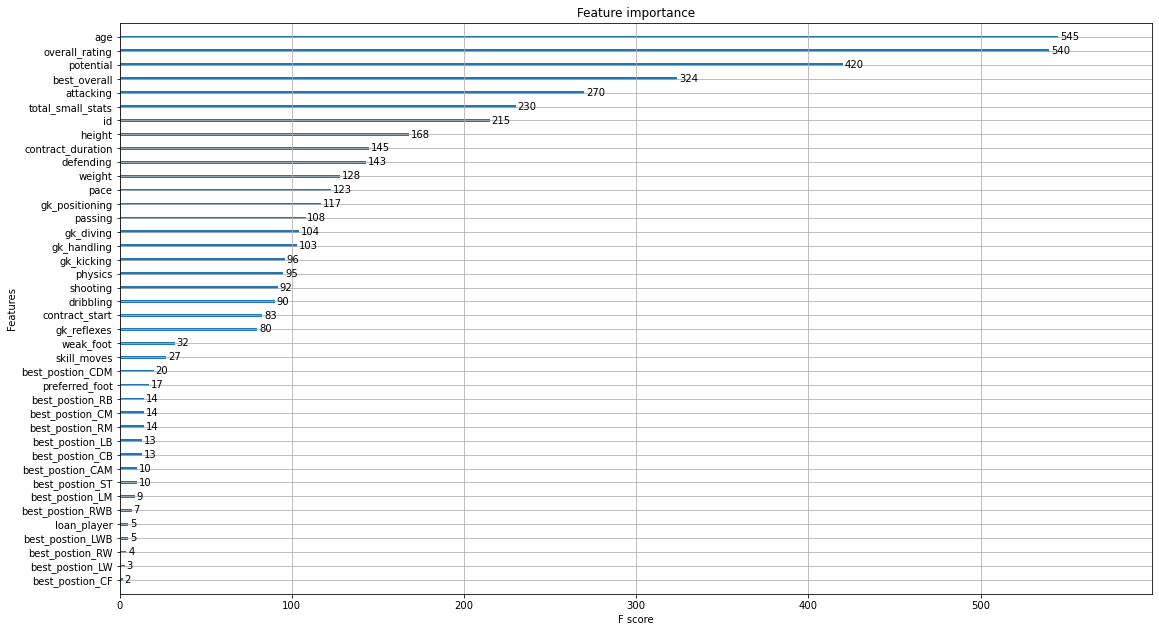

In [46]:
# Best model
params = xgb_bo.best_params_

xgb_best_model = xgb.XGBRegressor(random_state=42, **params)
xgb_best_model.fit(features, target)

fig = xgb.plot_importance(xgb_best_model)
fig = fig.figure 
fig.set_size_inches(18.5, 10.5)